In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from skimage import io
import numpy as np
import os
from PIL import Image

In [2]:
!cp '/content/drive/MyDrive/soft_computing/Dataset_2/verification_test.csv' '/content/sample_data'

In [3]:
!cp '/content/drive/MyDrive/soft_computing/Dataset_2/verification_train.csv' '/content/sample_data'

In [4]:
training_csv = pd.read_csv('/content/sample_data/verification_train.csv')
training_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [5]:
testing_csv = pd.read_csv('/content/sample_data/verification_test.csv')
testing_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [6]:
batch_size = 128
num_iters = 50000
input_dim = 28*28 # num_features = 784
# num_hidden = 600 # num of hidden nodes
output_dim = 10

learning_rate = 0.001  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
class OnkoDataset(Dataset):
    def __init__(self, csv, transform = None):
        self.annotations = csv
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        image = self.annotations.iloc[index, 1:]
        image = np.array(image, dtype = 'float32').reshape(28,28)
        y_label = torch.tensor(int(self.annotations.iloc[index, 0]))

        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [8]:
transform_dataset = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(28),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = OnkoDataset(csv = training_csv, transform=transform_dataset)
test_dataset = OnkoDataset(csv = testing_csv, transform=transform_dataset)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

In [9]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [10]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        ### 1st hidden layer: 784 --> 200
        self.linear_1 = nn.Linear(input_size, 1024)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        # ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(1024, 512)
        # ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        # ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(512, 256)
        # ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        # ### 4th hidden layer: 200 --> 200
        # self.linear_4 = nn.Linear(1200, 1000)
        # ### Non-linearity in 4th hidden layer
        # self.relu_4 = nn.ReLU()

        # ### 5th hidden layer: 200 --> 200
        # self.linear_5 = nn.Linear(1000, 500)
        # ### Non-linearity in 5th hidden layer
        # self.relu_5 = nn.ReLU()

        # ### 6th hidden layer: 200 --> 200
        # self.linear_6 = nn.Linear(750, 375)
        # ### Non-linearity in 6th hidden layer
        # self.relu_6 = nn.ReLU()

        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(256, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        # ### 2nd hidden layer
        out  = self.linear_2(out)
        # ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        # ### 3rd hidden layer
        out  = self.linear_3(out)
        # ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        # ### 4th hidden layer
        # out  = self.linear_4(out)
        # ### Non-linearity in 4th hidden layer
        # out = self.relu_4(out)

        # ### 5th hidden layer
        # out  = self.linear_5(out)
        # ### Non-linearity in 4th hidden layer
        # out = self.relu_5(out)

        # ### 6th hidden layer
        # out  = self.linear_6(out)
        # ### Non-linearity in 5th hidden layer
        # out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=1024, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=1024, out_features=512, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=512, out_features=256, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=256, out_features=10, bias=True)
)

In [11]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_values = []
accuracy_values = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels.long())

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, input_dim).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            loss_values.append(loss.item())
            accuracy_values.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.46272656321525574. Accuracy: 76.61
Iteration: 1000. Loss: 0.5835368037223816. Accuracy: 79.9
Iteration: 1500. Loss: 0.5190274119377136. Accuracy: 81.6
Iteration: 2000. Loss: 0.45045116543769836. Accuracy: 81.94
Iteration: 2500. Loss: 0.32739800214767456. Accuracy: 82.75
Iteration: 3000. Loss: 0.56279057264328. Accuracy: 83.03
Iteration: 3500. Loss: 0.4153044521808624. Accuracy: 83.09
Iteration: 4000. Loss: 0.41149118542671204. Accuracy: 83.85
Iteration: 4500. Loss: 0.4162648022174835. Accuracy: 83.89
Iteration: 5000. Loss: 0.48493120074272156. Accuracy: 84.39
Iteration: 5500. Loss: 0.4191049337387085. Accuracy: 84.59
Iteration: 6000. Loss: 0.3964821994304657. Accuracy: 84.04
Iteration: 6500. Loss: 0.44257551431655884. Accuracy: 84.21
Iteration: 7000. Loss: 0.48190343379974365. Accuracy: 84.67
Iteration: 7500. Loss: 0.5172878503799438. Accuracy: 85.54
Iteration: 8000. Loss: 0.4345014691352844. Accuracy: 85.39
Iteration: 8500. Loss: 0.4104461669921875. Accuracy: 8

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

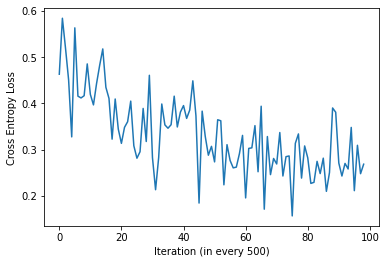

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files

# print (loss_values)
plt.plot(loss_values)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
# plt.show()
plt.savefig('exp_new_loss_2.png',  bbox_inches="tight")
files.download('exp_new_loss_2.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

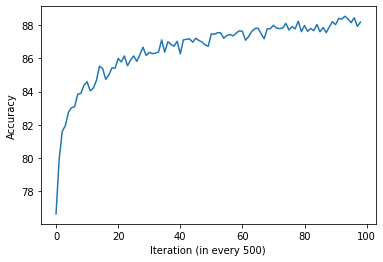

In [13]:
plt.plot(accuracy_values)
plt.ylabel('Accuracy')
plt.xlabel('Iteration (in every 500)')
# plt.show()
plt.savefig('exp_new_acc_2.png',  bbox_inches="tight")
files.download('exp_new_acc_2.png')

In [14]:
torch.save(model.state_dict(), 'exp_train_2.pkl') 
files.download('exp_train_2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>